
Verwendetes Szenario: office
Ladepunkte: 5
Zeitraum: 2025-03-29 00:00:00+01:00 bis 2025-04-02 23:45:00+02:00
Horizont: 5 Tage
Daytypes: {'working_day': 3, 'saturday': 1, 'sunday_holiday': 1}

Sessions
Ankünfte mit Ladebedarf: 34
mit Ladezugang: 16
ohne Ladezugang (drive_off): 18
Ziel-SoC nicht erreicht: 2


,session_id,charger_id,arrival_time,parking_duration_min,soc_arrival,soc_end,remaining_energy_kwh
0,2025-03-31_002_00006,3,2025-03-31 09:00:00+02:00,360.0,0.306567,0.753780,15.904171
1,2025-03-31_002_00002,1,2025-03-31 08:30:00+02:00,405.0,0.371118,0.919656,2.491405


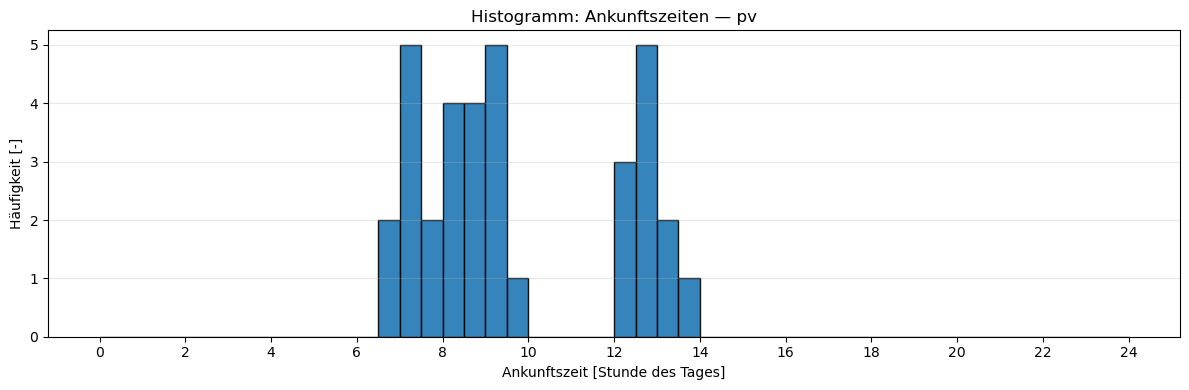

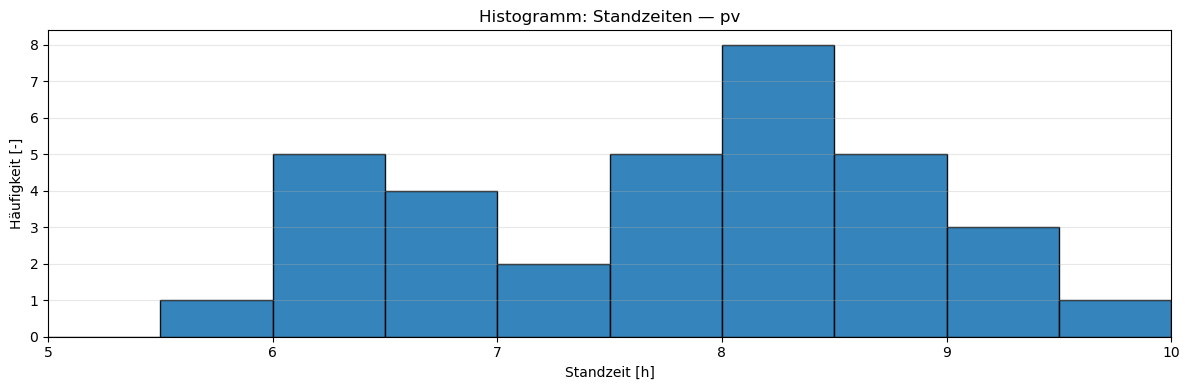

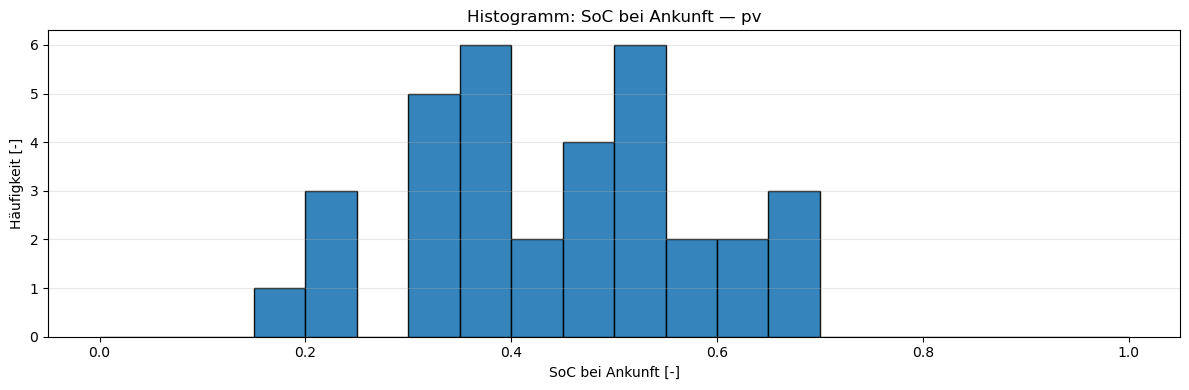

/var/folders/r3/k90znz0s1x79cnzkp10t2gcm0000gn/T/ipykernel_47453/805040644.py:469: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper left", ncols=2)


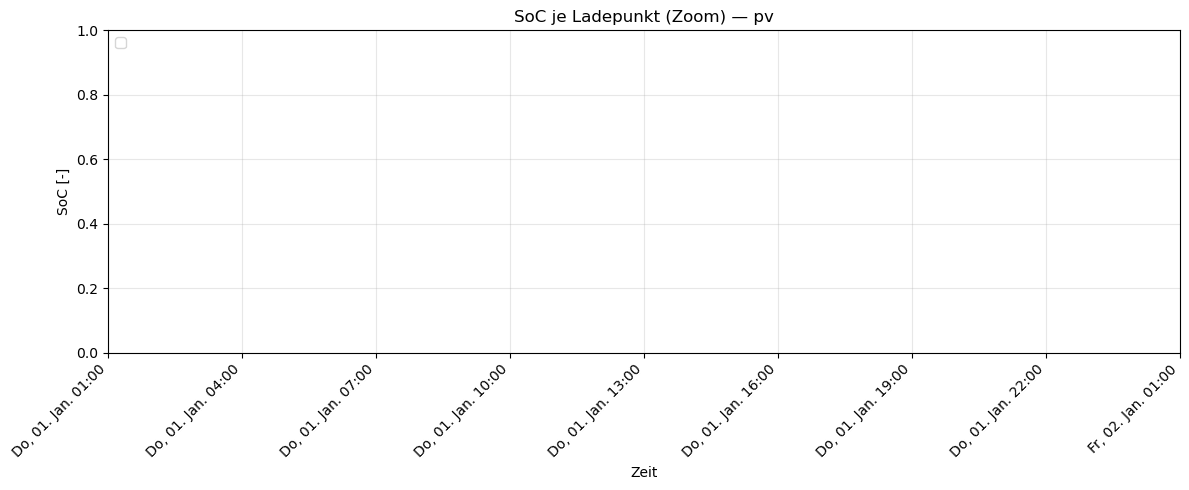

plugged sessions: 16
charger_traces rows: 473
vehicle_curves keys: 54
unique vehicle_names (first 10): ['BMW iX xDrive50' 'VW ID.7 Tourer' 'VW ID.4 Pro S' 'Polestar 2 LR DM'
 'Porsche Taycan' 'Hyundai IONIQ 5' 'Tesla Model 3' 'Genesis GV60'
 'Hyundai IONIQ 6' 'Tesla Model Y']
Überschreitungen: 0


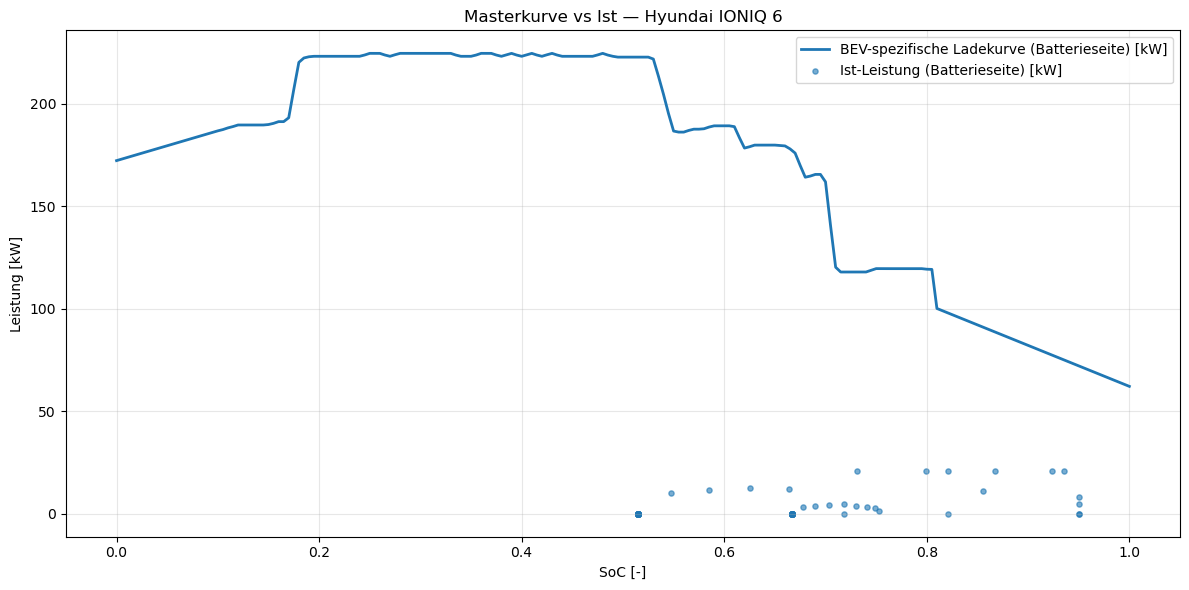

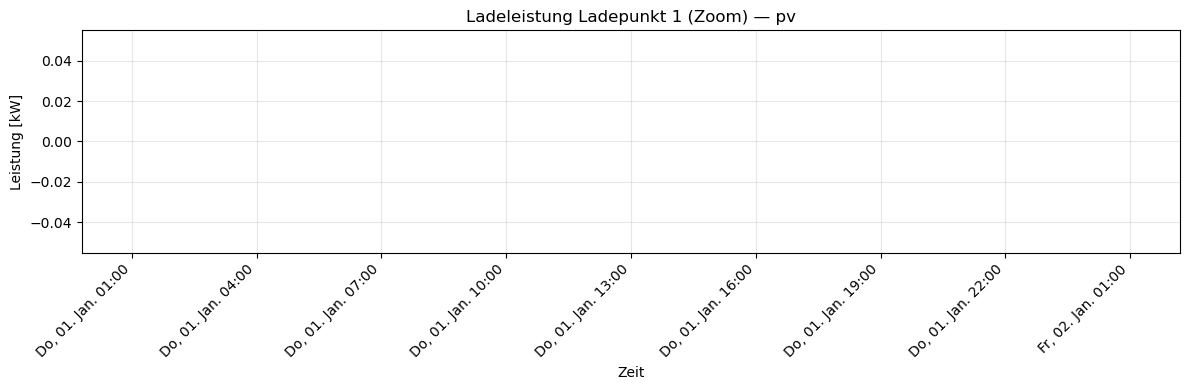

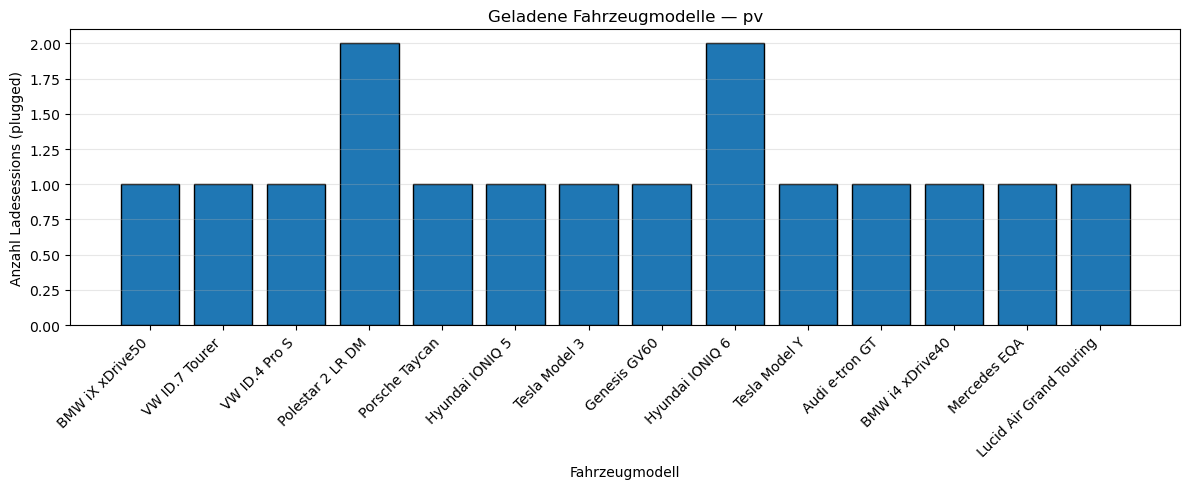

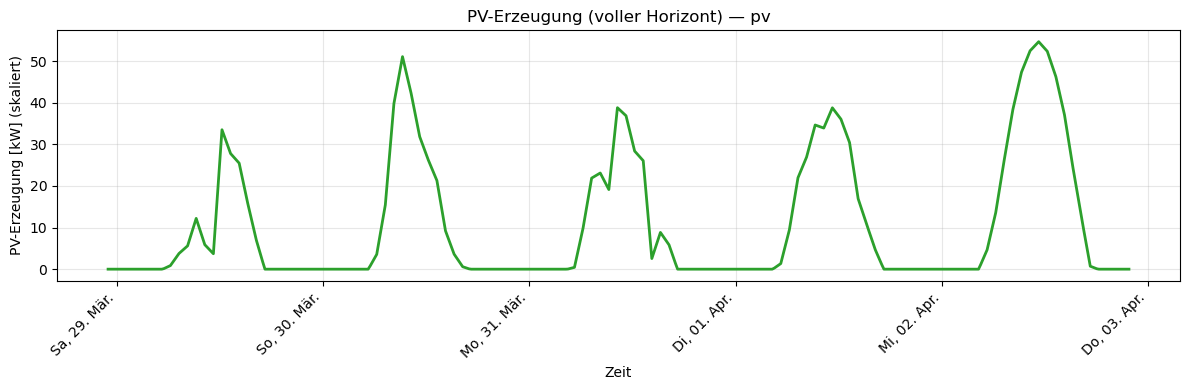

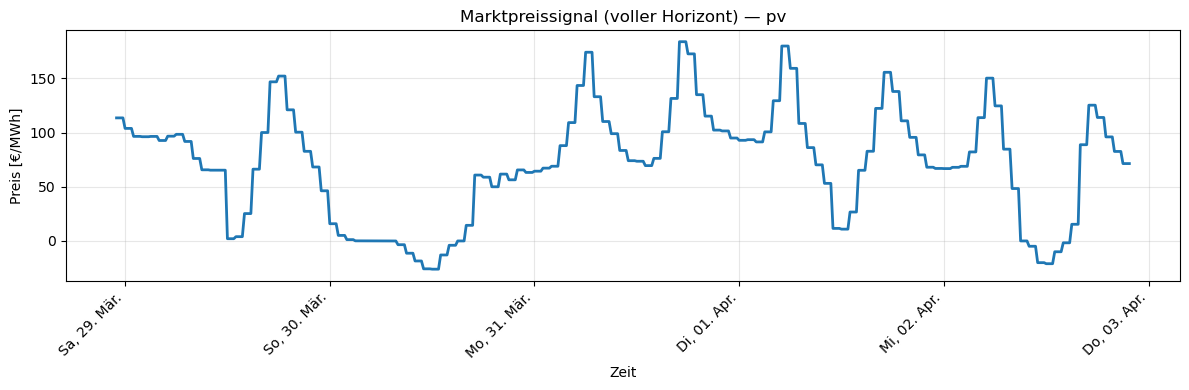

/var/folders/r3/k90znz0s1x79cnzkp10t2gcm0000gn/T/ipykernel_47453/805040644.py:620: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  im = ax.imshow(heatmap["matrix"], aspect="auto", interpolation="nearest")
/var/folders/r3/k90znz0s1x79cnzkp10t2gcm0000gn/T/ipykernel_47453/805040644.py:620: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  im = ax.imshow(heatmap["matrix"], aspect="auto", interpolation="nearest")


IndexError: list index out of range

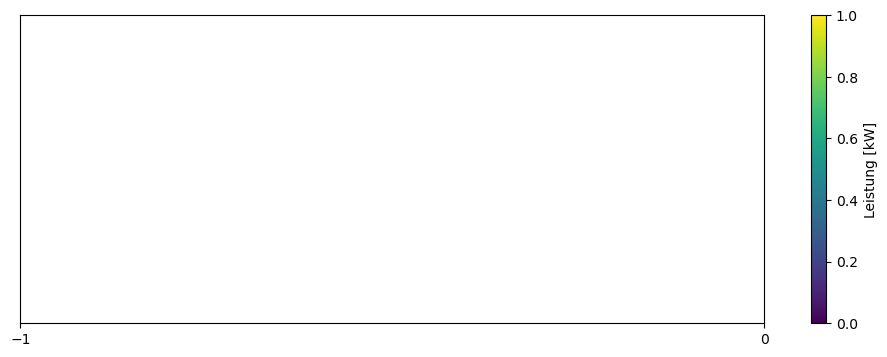

In [1]:
# =============================================================================
# A) Scenario Setup + Notebook-Parameter
# =============================================================================
scenario_name = "office"
scenario_path = f"../scenarios/{scenario_name}.yaml"                                    

zoom_days = 1
random_seed = 43

preview_rows_n = 10             # Anzahl Zeilen in der Plugged-Sessions-Vorschau

# =============================================================================
# B) Imports 
# =============================================================================
import warnings
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import model.simulation as sim

from collections import Counter
from matplotlib.ticker import FuncFormatter
from IPython.display import display
from zoneinfo import ZoneInfo

warnings.simplefilter("default", UserWarning)

# =============================================================================
# C) Plot Voreinstellungen (semantisch konsistent)
# =============================================================================
COLOR_PV = "#2ca02c"          # grün
COLOR_MARKET = "#1f77b4"      # blau
COLOR_GRID = COLOR_MARKET
COLOR_IMMEDIATE = "#d62728"   # rot
COLOR_SITE_LOAD = "#ff7f0e"   # orange
COLOR_BASELOAD = "#7f7f7f"    # grau
COLOR_TOTAL = "black"
COLOR_GRID_LIMIT = "black"

GERMAN_WEEKDAYS = ["Mo", "Di", "Mi", "Do", "Fr", "Sa", "So"]
GERMAN_MONTHS = ["Jan.", "Feb.", "Mär.", "Apr.", "Mai", "Jun.", "Jul.", "Aug.", "Sep.", "Okt.", "Nov.", "Dez."]

FIGSIZE_WIDE = (12, 4)
FIGSIZE_MEDIUM = (12, 5)
FIGSIZE_TALL = (12, 6)

# =============================================================================
# D) Notebook Helper Functions
# =============================================================================

def first_existing_column(dataframe: pd.DataFrame, candidates: list[str]) -> str | None:
    """
    Gibt den ersten Spaltennamen aus `candidates` zurück, der in `dataframe.columns` existiert.
    Wenn keine Kandidaten existieren, wird None zurückgegeben.
    """
    for name in candidates:
        if name in dataframe.columns:
            return name
    return None


def apply_german_time_axis(
    ax,
    tz: str = "Europe/Berlin",
    show_time: bool = False,
    rotation: int = 45,
    ha: str = "right",
    minticks: int = 4,
    maxticks: int = 10,
):
    """
    Formatiert die x-Achse in Deutsch:
      - ohne Uhrzeit:  'Mo, 31. Jan.'
      - mit Uhrzeit:   'Mo, 31. Jan. 23:00'
    """
    tzinfo = ZoneInfo(tz)

    def _fmt(x, pos=None):
        dt = mdates.num2date(x).astimezone(tzinfo)
        wd = GERMAN_WEEKDAYS[dt.weekday()]
        mon = GERMAN_MONTHS[dt.month - 1]
        if show_time:
            return f"{wd}, {dt.day:02d}. {mon} {dt:%H:%M}"
        return f"{wd}, {dt.day:02d}. {mon}"

    ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=minticks, maxticks=maxticks))
    ax.xaxis.set_major_formatter(FuncFormatter(_fmt))

    for lbl in ax.get_xticklabels():
        lbl.set_rotation(rotation)
        lbl.set_ha(ha)


# =============================================================================
# E) Shortcuts (Builder + Kernfunktionen)
# =============================================================================
load_scenario = sim.read_scenario_from_yaml

build_plugged_sessions_preview_table = sim.build_plugged_sessions_preview_table
summarize_sessions = sim.summarize_sessions

build_power_per_charger_timeseries = sim.build_power_per_charger_timeseries
build_soc_timeseries_by_charger = sim.build_soc_timeseries_by_charger
build_charger_power_heatmap_matrix = sim.build_charger_power_heatmap_matrix
build_ev_power_by_source_timeseries = sim.build_ev_power_by_source_timeseries
build_site_overview_plot_data = sim.build_site_overview_plot_data
build_ev_power_by_mode_timeseries_dataframe = sim.build_ev_power_by_mode_timeseries_dataframe

# =============================================================================
# F) Load scenario + resolve relative paths
# =============================================================================
scenario = sim.read_scenario_from_yaml(scenario_path)
scenario = sim.resolve_paths_relative_to_yaml(scenario, scenario_path)

scenario["time_resolution_min"] = sim.get_time_resolution_min_from_scenario(scenario)
charging_strategy = sim.get_charging_strategy_from_scenario(scenario)
strategy_status = charging_strategy 

# =============================================================================
# G) Build timestamps + input time series
# =============================================================================
timestamps = sim.build_simulation_timestamps(scenario)
holiday_dates = sim.get_holiday_dates_from_scenario(scenario, timestamps)

time_resolution_min = int(scenario["time_resolution_min"])
step_hours = float(time_resolution_min) / 60.0

# ggf. aus Szenario oder fix:
timezone = "Europe/Berlin"  # oder scenario.get("timezone")

# --- ALLES aus einer CSV laden + skalieren ---
base_load_kwh_per_step, pv_generation_kwh_per_step, market_price_eur_per_mwh = (
    sim.read_local_load_pv_market_from_csv(
        csv_path=scenario["localload_pv_market_csv"],
        timestamps=timestamps,
        timezone=timezone,
        base_load_annual_kwh=float(scenario["site"]["base_load_annual_kwh"]),
        pv_system_size_kwp=float(scenario["site"]["pv_system_size_kwp"]),
        profiles_are_normalized=True,
    )
)

# fürs Plotten/DF
pv_generation_series = pv_generation_kwh_per_step
market_price_series = market_price_eur_per_mwh
pv_generation_ylabel = "PV [kWh/step]"
market_price_ylabel = "Preis [€/MWh]"

vehicle_charging_curves_by_name = sim.read_vehicle_load_profiles_from_csv(
    str(scenario["vehicles"]["vehicle_curve_csv"])
)


# =============================================================================
# H) Sample sessions + run simulation
# =============================================================================
random_generator = np.random.default_rng(int(random_seed))

start_datetime = pd.Timestamp(timestamps[0])

simulation_horizon_days = int(scenario["simulation_horizon_days"])

# Wichtig: start_datetime TZ-sicher aus timestamps nehmen (und auf Tagesstart normalisieren)
start_datetime = pd.Timestamp(timestamps[0]).normalize()

sampled_sessions_all_days = []

for day_index in range(simulation_horizon_days):
    simulation_day_start = start_datetime + pd.DateOffset(days=day_index)  # DST-sicher, tz-aware
    sampled_sessions_for_day = sim.sample_sessions_for_simulation_day(
        scenario=scenario,
        simulation_day_start=simulation_day_start,  # kein .to_pydatetime()
        timestamps=timestamps,
        holiday_dates=holiday_dates,
        vehicle_curves_by_name=vehicle_charging_curves_by_name,
        random_generator=random_generator,
        day_index=day_index,
    )
    sampled_sessions_all_days.extend(sampled_sessions_for_day)


# 1) Simulation (Core)
ev_load_kw, sessions_out, reserved_total_kwh, reserved_pv_kwh, debug_df = sim.simulate_site_fcfs_with_planning(
    scenario=scenario,
    timestamps=timestamps,
    sessions=sampled_sessions_all_days,
    vehicle_curves_by_name=vehicle_charging_curves_by_name,
    pv_generation_kwh_per_step=np.asarray(pv_generation_kwh_per_step, dtype=float),
    base_load_kwh_per_step=np.asarray(base_load_kwh_per_step, dtype=float),
    market_price_eur_per_mwh=np.asarray(market_price_eur_per_mwh, dtype=float),
    record_debug=True,
)

# 2) sessions_out anreichern (arrival_time / departure_time / duration etc.)
sessions_out = sim.enrich_sessions_out_with_metadata(
    sessions_out=sessions_out,
    sampled_sessions=sampled_sessions_all_days,
)

# 3) charger_traces_dataframe bauen (für SoC/Power/Heatmap)
charger_traces_dataframe = sim.build_charger_traces_dataframe(
    sessions_out=sessions_out,
    scenario=scenario,
    vehicle_curves_by_name=vehicle_charging_curves_by_name,
    timestamps=timestamps,
)

# 4) timeseries_dataframe bauen (für Standortplots)
timeseries_dataframe = sim.build_timeseries_dataframe(
    timestamps=timestamps,
    scenario=scenario,
    base_load_kwh_per_step=base_load_kwh_per_step,
    pv_generation_kwh_per_step=pv_generation_kwh_per_step,
    ev_load_kw=ev_load_kw,
    market_price_eur_per_mwh=market_price_eur_per_mwh,
    debug_df=debug_df,  # optional
)

# 5) Zoom-Fenster
window_start, window_end = sim.initialize_time_window(
    timestamps=timestamps,
    scenario=scenario,
    days=zoom_days,
)

# optional kompatibel halten
debug_rows = [] if debug_df is None else debug_df.to_dict("records")

site_configuration = scenario["site"]

# =============================================================================
# I) KPIs
# =============================================================================
print("\nVerwendetes Szenario:", scenario_name)
print("Ladepunkte:", int(site_configuration["number_chargers"]))
print("Zeitraum:", timestamps[0], "bis", timestamps[-1])
print("Horizont:", simulation_horizon_days, "Tage")

daytypes_calendar = sim.get_daytype_calendar(
    start_datetime=start_datetime,
    horizon_days=simulation_horizon_days,
    holiday_dates=holiday_dates,
)

sessions_by_day = sim.group_sessions_by_day(sessions_out, only_plugged=False)
sessions_by_day_plugged = sim.group_sessions_by_day(sessions_out, only_plugged=True)
print("Daytypes:", {k: len(v) for k, v in daytypes_calendar.items()})

summary = summarize_sessions(sessions_out)
print("\nSessions")
print("Ankünfte mit Ladebedarf:", summary["num_sessions_total"])
print("mit Ladezugang:", summary["num_sessions_plugged"])
print("ohne Ladezugang (drive_off):", summary["num_sessions_rejected"])

not_reached_dataframe = pd.DataFrame(summary["not_reached_rows"])

if len(not_reached_dataframe) == 0:
    print("Alle Fahrzeuge haben Ziel-SoC erreicht.")
else:
    # Falls du im Summary schon "remaining_energy_kwh" hast: passt.
    # Falls es mal "remaining_energy" heißen sollte -> zurückbenennen:
    if "remaining_energy" in not_reached_dataframe.columns and "remaining_energy_kwh" not in not_reached_dataframe.columns:
        not_reached_dataframe = not_reached_dataframe.rename(columns={"remaining_energy": "remaining_energy_kwh"})

    # Sortierung
    sort_col = "remaining_energy_kwh" if "remaining_energy_kwh" in not_reached_dataframe.columns else None
    if sort_col is not None:
        not_reached_dataframe = not_reached_dataframe.sort_values(sort_col, ascending=False).reset_index(drop=True)
    else:
        not_reached_dataframe = not_reached_dataframe.reset_index(drop=True)

    # Gewünschte Reihenfolge (nur nehmen, was existiert)
    wanted_cols = [
        "session_id",
        "charger_id",
        "arrival_time",
        "parking_duration_min",
        "soc_arrival",
        "soc_end",
        "remaining_energy_kwh",
    ]
    existing_wanted_cols = [c for c in wanted_cols if c in not_reached_dataframe.columns]
    other_cols = [c for c in not_reached_dataframe.columns if c not in existing_wanted_cols]
    not_reached_dataframe = not_reached_dataframe[existing_wanted_cols + other_cols]

    # vehicle_name sicher entfernen, falls er doch drin ist
    if "vehicle_name" in not_reached_dataframe.columns:
        not_reached_dataframe = not_reached_dataframe.drop(columns=["vehicle_name"])

    print("Ziel-SoC nicht erreicht:", len(not_reached_dataframe))
    display(not_reached_dataframe)


# =============================================================================
# J) PLOTS
# =============================================================================
# Timezone
TZ = str(scenario.get("timezone", "Europe/Berlin"))
tzinfo = ZoneInfo(TZ)

# 1) Histogramme der Eingangsdaten
only_plugged = False  # True = nur status=="plugged", False = alle Sessions inkl. drive_off
_sessions = [s for s in sessions_out if s.get("status") == "plugged"] if only_plugged else list(sessions_out)

# 1a) Ankunftszeiten (Uhrzeit im Tagesverlauf)
arrival_raw = [s.get("arrival_time") for s in _sessions]
arrival_series = pd.to_datetime(pd.Series(arrival_raw), errors="coerce").dropna()

# lokal in Scenario-TZ
if arrival_series.dt.tz is not None:
    arrival_local = arrival_series.dt.tz_convert(tzinfo)
else:
    arrival_local = arrival_series.dt.tz_localize(tzinfo)

arrival_hour = arrival_local.dt.hour + arrival_local.dt.minute / 60.0

plt.figure(figsize=FIGSIZE_WIDE)
plt.hist(arrival_hour, bins=np.arange(0, 24.5, 0.5), edgecolor="black", alpha=0.9)
plt.xlabel("Ankunftszeit [Stunde des Tages]")
plt.ylabel("Häufigkeit [-]")
plt.title(sim.decorate_title_with_status("Histogramm: Ankunftszeiten", charging_strategy, strategy_status))
plt.grid(True, axis="y", alpha=0.3)
plt.xticks(range(0, 25, 2))
plt.tight_layout()
plt.show()

# 1b) Standzeiten (Parkdauer in Stunden)
arrival_series2 = pd.to_datetime(pd.Series([s.get("arrival_time") for s in _sessions]), errors="coerce")
departure_series = pd.to_datetime(pd.Series([s.get("departure_time") for s in _sessions]), errors="coerce")

tmp = pd.DataFrame({"arrival": arrival_series2, "departure": departure_series}).dropna()

# Falls tz-naiv: als lokale Zeit interpretieren (damit Differenzen konsistent sind)
if tmp["arrival"].dt.tz is None:
    tmp["arrival"] = tmp["arrival"].dt.tz_localize(tzinfo)
if tmp["departure"].dt.tz is None:
    tmp["departure"] = tmp["departure"].dt.tz_localize(tzinfo)

tmp["parking_duration_h"] = (tmp["departure"] - tmp["arrival"]).dt.total_seconds() / 3600.0
parking_duration_h = tmp["parking_duration_h"].dropna()
parking_duration_h = parking_duration_h[parking_duration_h >= 0]

# --- flexible Achse für Standzeiten (Minuten vs. Stunden, nicht bei 0 starten) ---
dur_h = parking_duration_h.to_numpy(dtype=float)
dur_h = dur_h[np.isfinite(dur_h) & (dur_h >= 0)]

if dur_h.size == 0:
    print("Keine gültigen Standzeiten vorhanden.")
else:
    dur_min = dur_h * 60.0

    # Schwellwert: bis inkl. 4h lieber Minuten-Achse, darüber Stunden-Achse
    minutes_threshold_h = 4.0
    use_minutes = float(dur_h.max()) <= minutes_threshold_h

    if use_minutes:
        x = dur_min
        xlabel = "Standzeit [min]"
        span = float(x.max() - x.min())

        # Tick-/Bin-Breite in Minuten (einfach & gut lesbar)
        if span <= 180:
            tick_step = 10
        elif span <= 360:
            tick_step = 30
        else:
            tick_step = 60

        bin_width = tick_step  # Histogramm-Bins passend zu Ticks
    else:
        x = dur_h
        xlabel = "Standzeit [h]"
        span = float(x.max() - x.min())

        # Bins in Stunden (halb-stündlich bei kleineren Spannweiten)
        bin_width = 0.5 if span <= 6 else 1.0

        # Ticks in ganzen Stunden (bei sehr großen Bereichen ggf. ausdünnen)
        full_hours_range = float(np.ceil(x.max()) - np.floor(x.min()))
        tick_step = 1 if full_hours_range <= 12 else 2

    # Achsenbereich an Daten ausrichten (statt bei 0 starten)
    start_tick = float(np.floor(x.min() / tick_step) * tick_step)
    end_tick = float(np.ceil(x.max() / tick_step) * tick_step)

    # Bins bauen
    bins = np.arange(start_tick, end_tick + bin_width, bin_width)
    if bins.size < 2:
        bins = 10  # Fallback

    plt.figure(figsize=FIGSIZE_WIDE)
    plt.hist(x, bins=bins, edgecolor="black", alpha=0.9)
    plt.xlabel(xlabel)
    plt.ylabel("Häufigkeit [-]")
    plt.title(sim.decorate_title_with_status("Histogramm: Standzeiten", charging_strategy, strategy_status))
    plt.grid(True, axis="y", alpha=0.3)

    # Ticks setzen
    ticks = np.arange(start_tick, end_tick + 0.5 * tick_step, tick_step)
    if use_minutes:
        ticks = ticks.astype(int)  # hübsch ohne .0
    plt.xticks(ticks)

    plt.xlim(start_tick, end_tick)
    plt.tight_layout()
    plt.show()


# 1c) SoC bei Ankunft
soc_arrival = pd.to_numeric(
    pd.Series([s.get("state_of_charge_at_arrival", np.nan) for s in _sessions]),
    errors="coerce",
).dropna()
soc_arrival = soc_arrival[(soc_arrival >= 0.0) & (soc_arrival <= 1.0)]

plt.figure(figsize=FIGSIZE_WIDE)
plt.hist(soc_arrival, bins=np.linspace(0, 1, 21), edgecolor="black", alpha=0.9)
plt.xlabel("SoC bei Ankunft [-]")
plt.ylabel("Häufigkeit [-]")
plt.title(sim.decorate_title_with_status("Histogramm: SoC bei Ankunft", charging_strategy, strategy_status))
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


# 2) SoC je Ladepunkt (Zoom)
soc_by_charger_id = build_soc_timeseries_by_charger(
    charger_traces_dataframe=charger_traces_dataframe,
    charger_ids=list(range(int(site_configuration["number_chargers"]))),
    start=window_start,
    end=window_end,
)

plt.figure(figsize=FIGSIZE_MEDIUM)

for charger_id, soc_dataframe in soc_by_charger_id.items():
    if soc_dataframe is None or len(soc_dataframe) == 0:
        continue

    if "session_id" not in soc_dataframe.columns:
        plt.plot(
            soc_dataframe["timestamp"],
            soc_dataframe["soc"],
            linewidth=1.5,
            label=f"Ladepunkt {charger_id + 1}",
        )
        continue

    soc_dataframe = soc_dataframe.sort_values("timestamp")
    first_segment = True

    for _, segment in soc_dataframe.groupby("session_id"):
        if len(segment) < 2:
            continue

        plt.plot(
            segment["timestamp"],
            segment["soc"],
            linewidth=1.5,
            label=f"Ladepunkt {charger_id + 1}" if first_segment else None,
        )
        first_segment = False

plt.xlabel("Zeit")
plt.ylabel("SoC [-]")
plt.title(sim.decorate_title_with_status("SoC je Ladepunkt (Zoom)", charging_strategy, strategy_status))
plt.grid(True, alpha=0.3)
plt.legend(loc="upper left", ncols=2)

apply_german_time_axis(plt.gca(), tz=TZ, show_time=True)
plt.tight_layout()
plt.show()


print("plugged sessions:", sum(s.get("status") == "plugged" for s in sessions_out))
print("charger_traces rows:", len(charger_traces_dataframe))
print("vehicle_curves keys:", len(vehicle_charging_curves_by_name))

if len(charger_traces_dataframe) > 0 and "vehicle_name" in charger_traces_dataframe.columns:
    print("unique vehicle_names (first 10):",
          charger_traces_dataframe["vehicle_name"].dropna().astype(str).unique()[:10])
else:
    print("charger_traces_dataframe ist leer oder hat keine Spalte 'vehicle_name'")

# 3) Kurvenvalidierung – CSV-Ladekurve (Batterieseite) vs. Ist-Ladekurve (Batterieseite)
most_used_vehicle_name = sim.get_most_used_vehicle_name(
    sessions_out=sessions_out,
    charger_traces_dataframe=charger_traces_dataframe,
    only_plugged_sessions=True,
)

plot_data = sim.build_master_curve_and_actual_points_for_vehicle(
    charger_traces_dataframe=charger_traces_dataframe,
    scenario=scenario,
    curve=vehicle_charging_curves_by_name[most_used_vehicle_name],  # <- Variante 2
    start=None,
    end=None,
)

print("Überschreitungen:", plot_data["number_violations"])

plt.figure(figsize=FIGSIZE_TALL)
plt.plot(
    plot_data["master_soc"],
    plot_data["master_power_battery_kw"],
    linewidth=2,
    label="BEV-spezifische Ladekurve (Batterieseite) [kW]",
)

plt.scatter(
    plot_data["actual_soc"],
    plot_data["actual_power_batt_kw"],
    s=14,
    alpha=0.6,
    label="Ist-Leistung (Batterieseite) [kW]",
)

if plot_data["number_violations"] > 0:
    mask = plot_data["violation_mask"]
    plt.scatter(
        plot_data["actual_soc"][mask],
        plot_data["actual_power_batt_kw"][mask],
        s=30,
        alpha=0.9,
        color="red",
        label=f"Überschreitungen (n={plot_data['number_violations']})",
    )

plt.xlabel("SoC [-]")
plt.ylabel("Leistung [kW]")
plt.title(f"Masterkurve vs Ist — {plot_data['vehicle_name']}")
plt.grid(True, alpha=0.3)
plt.legend(loc="best")
plt.tight_layout()
plt.show()


# 4) Leistung eines Ladepunkts (Zoom)
charger_id_to_plot = 0
charger_label = charger_id_to_plot + 1

charger_power_dataframe = build_power_per_charger_timeseries(
    charger_traces_dataframe,
    charger_id=charger_id_to_plot,
    start=window_start,
    end=window_end,
)

plt.figure(figsize=FIGSIZE_WIDE)
plt.plot(
    charger_power_dataframe["timestamp"],
    charger_power_dataframe["power_kw"],
    color=COLOR_SITE_LOAD,
    linewidth=2,
)
plt.xlabel("Zeit")
plt.ylabel("Leistung [kW]")
plt.title(sim.decorate_title_with_status(f"Ladeleistung Ladepunkt {charger_label} (Zoom)", charging_strategy, strategy_status))
plt.grid(True, alpha=0.3)

apply_german_time_axis(plt.gca(), tz=TZ, show_time=True)
plt.tight_layout()
plt.show()


# 5) Fahrzeugzählung (plugged Sessions)
plugged_sessions = [s for s in sessions_out if s.get("status") == "plugged"]
vehicle_counts = Counter([s.get("vehicle_name", "") for s in plugged_sessions])

plt.figure(figsize=FIGSIZE_MEDIUM)
plt.bar(list(vehicle_counts.keys()), list(vehicle_counts.values()), edgecolor="black")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Fahrzeugmodell")
plt.ylabel("Anzahl Ladesessions (plugged)")
plt.title(sim.decorate_title_with_status("Geladene Fahrzeugmodelle", charging_strategy, strategy_status))
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


# 6) PV-Erzeugung (voller Horizont)
if "pv_generation_kw" in timeseries_dataframe.columns and timeseries_dataframe["pv_generation_kw"].notna().any():
    plt.figure(figsize=FIGSIZE_WIDE)
    plt.plot(timeseries_dataframe["timestamp"], timeseries_dataframe["pv_generation_kw"], linewidth=2, color=COLOR_PV)
    plt.xlabel("Zeit")
    plt.ylabel("PV-Erzeugung [kW] (skaliert)")
    plt.title(sim.decorate_title_with_status("PV-Erzeugung (voller Horizont)", charging_strategy, strategy_status))
    plt.grid(True, alpha=0.3)

    apply_german_time_axis(plt.gca(), tz=TZ, show_time=False)
    plt.tight_layout()
    plt.show()
else:
    print("Kein pv_generation_kw in timeseries_dataframe.")


# 7) Marktpreissignal (voller Horizont)
if market_price_series is not None and market_price_ylabel is not None:
    plt.figure(figsize=FIGSIZE_WIDE)
    plt.plot(timestamps, market_price_series, linewidth=2, color=COLOR_MARKET)
    plt.xlabel("Zeit")
    plt.ylabel(market_price_ylabel)
    plt.title(sim.decorate_title_with_status("Marktpreissignal (voller Horizont)", charging_strategy, strategy_status))
    plt.grid(True, alpha=0.3)

    apply_german_time_axis(plt.gca(), tz=TZ, show_time=False)
    plt.tight_layout()
    plt.show()


# 8) Heatmap (Zoom) — Sonderfall: eigene xticks aus heatmap["timestamps"]
heatmap = build_charger_power_heatmap_matrix(
    charger_traces_dataframe,
    start=window_start,
    end=window_end,
)

fig, ax = plt.subplots(figsize=FIGSIZE_WIDE)
im = ax.imshow(heatmap["matrix"], aspect="auto", interpolation="nearest")
fig.colorbar(im, ax=ax, label="Leistung [kW]")

ax.set_yticks(np.arange(len(heatmap["charger_ids"])))
ax.set_yticklabels([f"Ladepunkt {int(i) + 1}" for i in heatmap["charger_ids"]])

# xticks sinnvoll ausdünnen
ts_list = [pd.to_datetime(t) for t in heatmap["timestamps"]]
n = len(ts_list)
tick_count = min(8, max(2, n // 10))
tick_idx = np.linspace(0, n - 1, tick_count).astype(int)

def _fmt_dt(dt, with_time=True):
    wd = GERMAN_WEEKDAYS[dt.weekday()]
    mon = GERMAN_MONTHS[dt.month - 1]
    if with_time:
        return f"{wd}, {dt.day:02d}. {mon} {dt:%H:%M}"
    return f"{wd}, {dt.day:02d}. {mon}"

ax.set_xticks(tick_idx)
ax.set_xticklabels([_fmt_dt(ts_list[i], with_time=True) for i in tick_idx], rotation=45, ha="right")

ax.set_title(sim.decorate_title_with_status("Heatmap Ladepunktleistung (Zoom)", charging_strategy, strategy_status))
ax.set_xlabel("Zeit")
ax.set_ylabel("Ladepunkt")
fig.tight_layout()
plt.show()


# 9) Standortlast gestapelt (voller Horizont)
plt.figure(figsize=FIGSIZE_WIDE)
plt.stackplot(
    timeseries_dataframe["timestamp"],
    timeseries_dataframe["base_load_kw"].astype(float).fillna(0.0),
    timeseries_dataframe["ev_load_kw"].astype(float).fillna(0.0),
    labels=["Grundlast", "EV-Ladeleistung"],
    colors=[COLOR_BASELOAD, COLOR_SITE_LOAD],
    alpha=0.9,
)
plt.xlabel("Zeit")
plt.ylabel("Leistung [kW]")
plt.title(sim.decorate_title_with_status("Standortlast – Grundlast + EV (gestapelt)", charging_strategy, strategy_status))
plt.legend(loc="upper right")
plt.grid(True, alpha=0.3)

apply_german_time_axis(plt.gca(), tz=TZ, show_time=False)
plt.tight_layout()
plt.show()


# 10) EV-Leistung nach Modus
mode_dataframe = build_ev_power_by_mode_timeseries_dataframe(
    timeseries_dataframe=timeseries_dataframe,
    sessions_out=sessions_out,
    scenario=scenario,
)

plt.figure(figsize=FIGSIZE_WIDE)
plt.stackplot(
    mode_dataframe["timestamp"],
    mode_dataframe["ev_generation_kw"],
    mode_dataframe["ev_market_kw"],
    mode_dataframe["ev_immediate_kw"],
    labels=["Generation (PV)", "Market", "Immediate"],
    colors=[COLOR_PV, COLOR_MARKET, COLOR_IMMEDIATE],
    alpha=0.9,
)
plt.xlabel("Zeit")
plt.ylabel("Leistung [kW]")
plt.title(sim.decorate_title_with_status("EV-Leistung nach Lademodus", charging_strategy, strategy_status))
plt.legend(loc="upper right")
plt.grid(True, alpha=0.3)

apply_german_time_axis(plt.gca(), tz=TZ, show_time=False)
plt.tight_layout()
plt.show()


# 11) EV-Leistung nach Quelle
ev_power_by_source_dataframe = build_ev_power_by_source_timeseries(timeseries_dataframe)

plt.figure(figsize=FIGSIZE_WIDE)
plt.stackplot(
    ev_power_by_source_dataframe["timestamp"],
    ev_power_by_source_dataframe["ev_from_pv_kw"],
    ev_power_by_source_dataframe["ev_from_grid_kw"],
    labels=["EV aus PV", "EV aus Netz"],
    colors=[COLOR_PV, COLOR_GRID],
    alpha=0.9,
)
plt.xlabel("Zeit")
plt.ylabel("Leistung [kW]")
plt.title(sim.decorate_title_with_status("EV-Leistung nach Stromquelle", charging_strategy, strategy_status))
plt.legend(loc="upper right")
plt.grid(True, alpha=0.3)

apply_german_time_axis(plt.gca(), tz=TZ, show_time=False)
plt.tight_layout()
plt.show()


# 12a) Standort-Übersicht (Zoom) – Fläche + PV + Marktpreis
site_overview_data = build_site_overview_plot_data(
    timeseries_dataframe=timeseries_dataframe,
    scenario=scenario,
    start=window_start,
    end=window_end,
)

overview_dataframe = site_overview_data["dataframe"]
total_load_kw = site_overview_data["total_load_kw"]
pv_generation_kw = site_overview_data["pv_generation_kw"]
grid_limit_kw = site_overview_data["grid_limit_kw"]

market_price_column = first_existing_column(
    overview_dataframe,
    ["market_price_eur_per_mwh", "market_price", "price_eur_per_mwh"],
)

fig, ax_load = plt.subplots(figsize=FIGSIZE_WIDE)

ax_load.fill_between(
    overview_dataframe["timestamp"],
    total_load_kw,
    color=COLOR_SITE_LOAD,
    alpha=0.5,
    label="Gesamtlast (Grundlast + EV)",
)

if pv_generation_kw is not None:
    ax_load.plot(
        overview_dataframe["timestamp"],
        pv_generation_kw,
        color=COLOR_PV,
        linestyle="-",
        linewidth=2,
        label="PV-Erzeugung",
    )

ax_load.axhline(
    grid_limit_kw,
    linestyle="--",
    linewidth=1.5,
    color=COLOR_GRID_LIMIT,
    label="Netzanschlussgrenze",
)

ax_load.set_xlabel("Zeit")
ax_load.set_ylabel("Leistung [kW]")
ax_load.grid(True, alpha=0.3)

# rechte Achse nur für Preis
ax_price = None
if market_price_column is not None:
    ax_price = ax_load.twinx()
    ax_price.plot(
        overview_dataframe["timestamp"],
        overview_dataframe[market_price_column],
        linestyle="-",
        linewidth=2,
        color=COLOR_MARKET,
        label="Marktpreis [€/kWh]",
    )
    ax_price.set_ylabel("Marktpreis [€/kWh]")

# Legende zusammenführen
lines, labels = ax_load.get_legend_handles_labels()
if ax_price is not None:
    lines2, labels2 = ax_price.get_legend_handles_labels()
    lines += lines2
    labels += labels2
ax_load.legend(lines, labels, loc="upper right")

ax_load.set_title(sim.decorate_title_with_status("Standort-Übersicht (Zoom)", charging_strategy, strategy_status))
apply_german_time_axis(ax_load, tz=TZ, show_time=True)
fig.tight_layout()
plt.show()


# 13b) Standort-Übersicht (gesamter Simulationshorizont)
site_overview_data_full = build_site_overview_plot_data(
    timeseries_dataframe=timeseries_dataframe,
    scenario=scenario,
    start=None,
    end=None,
)

overview_dataframe_full = site_overview_data_full["dataframe"]
total_load_kw_full = site_overview_data_full["total_load_kw"]
pv_generation_kw_full = site_overview_data_full["pv_generation_kw"]
grid_limit_kw_full = site_overview_data_full["grid_limit_kw"]

market_price_column = first_existing_column(
    overview_dataframe_full,
    ["market_price_eur_per_mwh", "market_price", "price_eur_per_mwh"],
)

fig, ax_load = plt.subplots(figsize=FIGSIZE_WIDE)

ax_load.fill_between(
    overview_dataframe_full["timestamp"],
    total_load_kw_full,
    color=COLOR_SITE_LOAD,
    alpha=0.5,
    label="Gesamtlast (Grundlast + EV)",
)

if pv_generation_kw_full is not None:
    ax_load.plot(
        overview_dataframe_full["timestamp"],
        pv_generation_kw_full,
        color=COLOR_PV,
        linestyle="--",
        linewidth=1.5,
        label="PV-Erzeugung",
    )

ax_load.axhline(
    grid_limit_kw_full,
    linestyle="--",
    linewidth=1.2,
    color=COLOR_GRID_LIMIT,
    label="Netzanschlussgrenze",
)

ax_load.set_xlabel("Zeit")
ax_load.set_ylabel("Leistung [kW]")
ax_load.grid(True, alpha=0.3)

ax_price = None
if market_price_column is not None:
    ax_price = ax_load.twinx()
    ax_price.plot(
        overview_dataframe_full["timestamp"],
        overview_dataframe_full[market_price_column],
        linestyle=":",
        linewidth=1.5,
        color=COLOR_MARKET,
        label="Marktpreis [€/kWh]",
    )
    ax_price.set_ylabel("Marktpreis [€/kWh]")

lines, labels = ax_load.get_legend_handles_labels()
if ax_price is not None:
    lines2, labels2 = ax_price.get_legend_handles_labels()
    lines += lines2
    labels += labels2
ax_load.legend(lines, labels, loc="upper right")

ax_load.set_title(sim.decorate_title_with_status("Standort-Übersicht (gesamter Simulationshorizont)", charging_strategy, strategy_status))
apply_german_time_axis(ax_load, tz=TZ, show_time=False)
fig.tight_layout()
plt.show()


# 14) Plugged Sessions Preview
display(build_plugged_sessions_preview_table(sessions_out, n=preview_rows_n))
